In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import torch
import cv2
import sys
from PIL import Image
from tqdm import tqdm

# %matplotlib inline
%config InlineBackend.figure_format = 'retina'
print(f"Pytorch Version:[{torch.__version__}]")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device:[{device}]")

Pytorch Version:[1.6.0]
device:[cuda:0]


In [2]:
os.getcwd()

'/opt/ml/code'

In [3]:
train_path = '../input/data/train'
test_path = '../input/data/eval'

In [4]:
class cfg:
    data_dir = '../input/data/train'
    img_dir = f'{data_dir}/images'
    df_path = f'{data_dir}/train.csv'

In [5]:
cfg.img_dir

'../input/data/train/images'

In [7]:
df_train = pd.read_csv(os.path.join(train_path, 'train.csv'))
df_test = pd.read_csv(os.path.join(test_path, 'info.csv'))

In [8]:
df_train.head()

id  gender   race  age                    path
0  000001  female  Asian   45  000001_female_Asian_45
1  000002  female  Asian   52  000002_female_Asian_52
2  000004    male  Asian   54    000004_male_Asian_54
3  000005  female  Asian   58  000005_female_Asian_58
4  000006  female  Asian   59  000006_female_Asian_59

In [9]:
df_train.shape

(2700, 5)

In [10]:
df_test.head()

ImageID  ans
0  cbc5c6e168e63498590db46022617123f1fe1268.jpg    0
1  0e72482bf56b3581c081f7da2a6180b8792c7089.jpg    0
2  b549040c49190cedc41327748aeb197c1670f14d.jpg    0
3  4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg    0
4  248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg    0

In [11]:
df_test.shape

(12600, 2)

In [12]:
df_test.ans.unique()  # test set에 labeling이 당연히 안되어 있다

array([0])

### 데이터셋의 이미지 크기와 RGB 평균 및 표준편차 수집

In [17]:
def get_img_stats(img_dir, img_ids):
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_id in tqdm(img_ids):
        for path in glob(os.path.join(img_dir, img_id, "*")):
            img = np.array(Image.open(path))
            h, w, _ = img.shape
            img_info["heights"].append(h)
            img_info["widths"].append(w)
            img_info["means"].append(img.mean(axis=(0, 1)))
            img_info["stds"].append(img.std(axis=(0, 1)))
    return img_info

In [18]:
df_train.path.values

array(['000001_female_Asian_45', '000002_female_Asian_52',
       '000004_male_Asian_54', ..., '006956_male_Asian_19',
       '006957_male_Asian_20', '006959_male_Asian_19'], dtype=object)

In [19]:
img_info = get_img_stats(cfg.img_dir, df_train.path.values)

100%|██████████| 2700/2700 [06:51<00:00,  6.56it/s]


In [28]:
print(f"Total number of people is {len(df_train)}")
print(f"Total number of images is {len(df_train) * 7}")

np.min(img_info["heights"])
print(f'Min height for dataset is {np.min(img_info["heights"])}')
print(f'Max height for dataset is {np.max(img_info["heights"])}')
print(f'Average height for dataset is {np.mean(img_info["heights"])}')
print(f'Min width for dataset is {np.min(img_info["widths"])}')
print(f'Max width for dataset is {np.max(img_info["widths"])}')
print(f'Average width for dataset is {np.mean(img_info["widths"])}')

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')

Total number of people is 2700
Total number of images is 18900
Min height for dataset is 512
Max height for dataset is 512
Average height for dataset is 512.0
Min width for dataset is 384
Max width for dataset is 384
Average width for dataset is 384.0
RGB Mean: [0.56019358 0.52410121 0.501457  ]
RGB Standard Deviation: [0.23318603 0.24300033 0.24567522]


### 데이터 구성
- train : images 폴더 안에 사람별로 폴더가 있고, 각 마스크 쓴 5개 + 잘못 쓴 1개 + 안쓴 1개 = 7개로 구성
- eval : images 폴더 안에 test 이미지 바로 있다

In [57]:
train_img_dir = []
train_img_paths = []
test_img_paths = []

In [58]:
for x in glob(os.path.join(train_path, "images", "*")):
    if os.path.isdir(x):
        train_img_dir.append(x)
len(train_img_dir)

2700

In [59]:
for x in train_img_dir:
    train_img_paths.append(glob(os.path.join(x, "*")))
len(train_img_paths)

2700

In [60]:
train_img_paths[0]

['../input/data/train/images/000523_female_Asian_51/mask4.jpg',
 '../input/data/train/images/000523_female_Asian_51/normal.jpg',
 '../input/data/train/images/000523_female_Asian_51/mask3.jpg',
 '../input/data/train/images/000523_female_Asian_51/mask1.jpg',
 '../input/data/train/images/000523_female_Asian_51/incorrect_mask.jpg',
 '../input/data/train/images/000523_female_Asian_51/mask5.jpg',
 '../input/data/train/images/000523_female_Asian_51/mask2.jpg']

In [61]:
test_img_paths = glob(os.path.join(test_path, "images", "*"))
len(test_img_paths)

12600

In [62]:
# 확장자 확인하기
train_extention = [y.split("/")[-1].split(".")[-1] for x in train_img_paths for y in x]
test_extention = [x.split("/")[-1].split(".")[-1] for x in test_img_paths]

In [63]:
set(train_extention)

{'jpeg', 'jpg', 'png'}

In [64]:
set(test_extention)

{'jpg'}

- 확장자는 jpeg, jpg, png로 이루어짐

### 데이터 시각화를 해보자

In [82]:
def show_images(path, N=7):
    fig, ax = plt.subplots(figsize=(20, 20), ncols=N)
    for i, p in enumerate(path):
        if i == N:
            break
        img = cv2.imread(p)
        ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

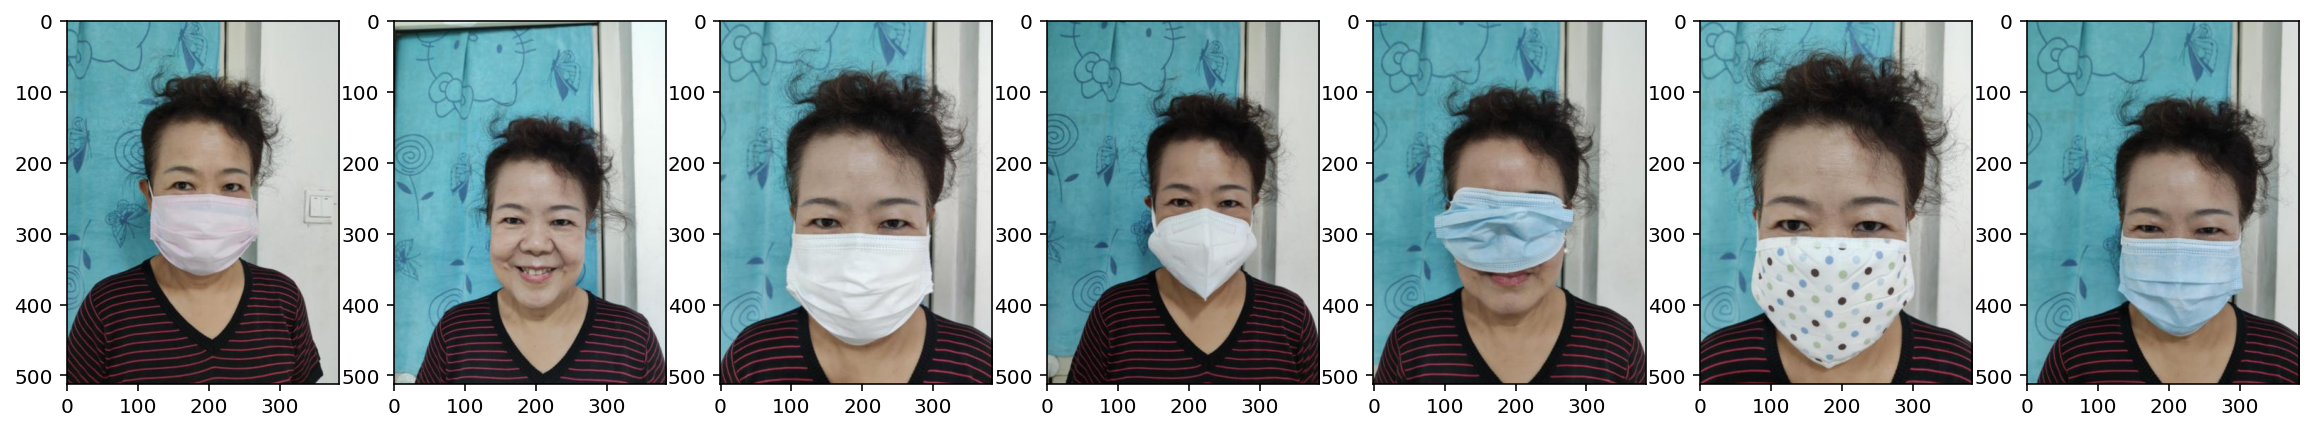

In [83]:
# train image
show_images(train_img_paths[0])

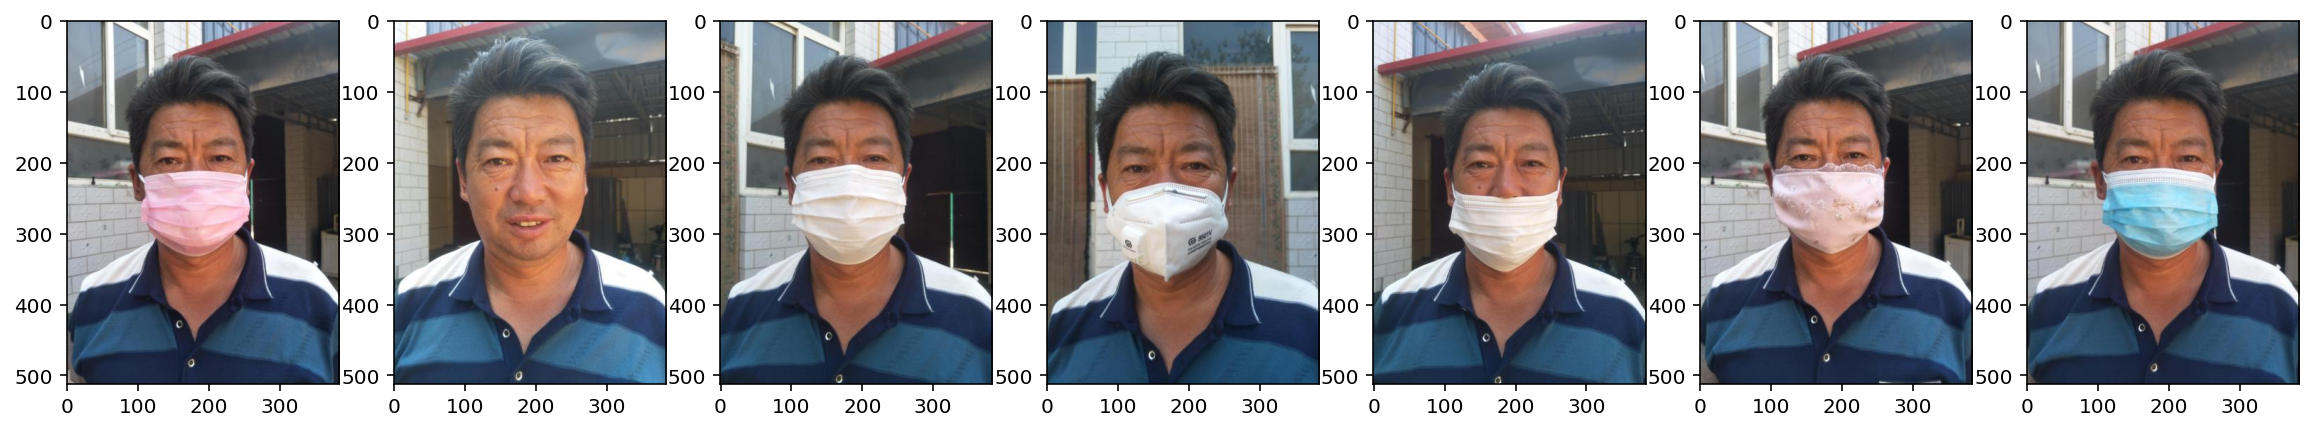

In [84]:
show_images(train_img_paths[10])

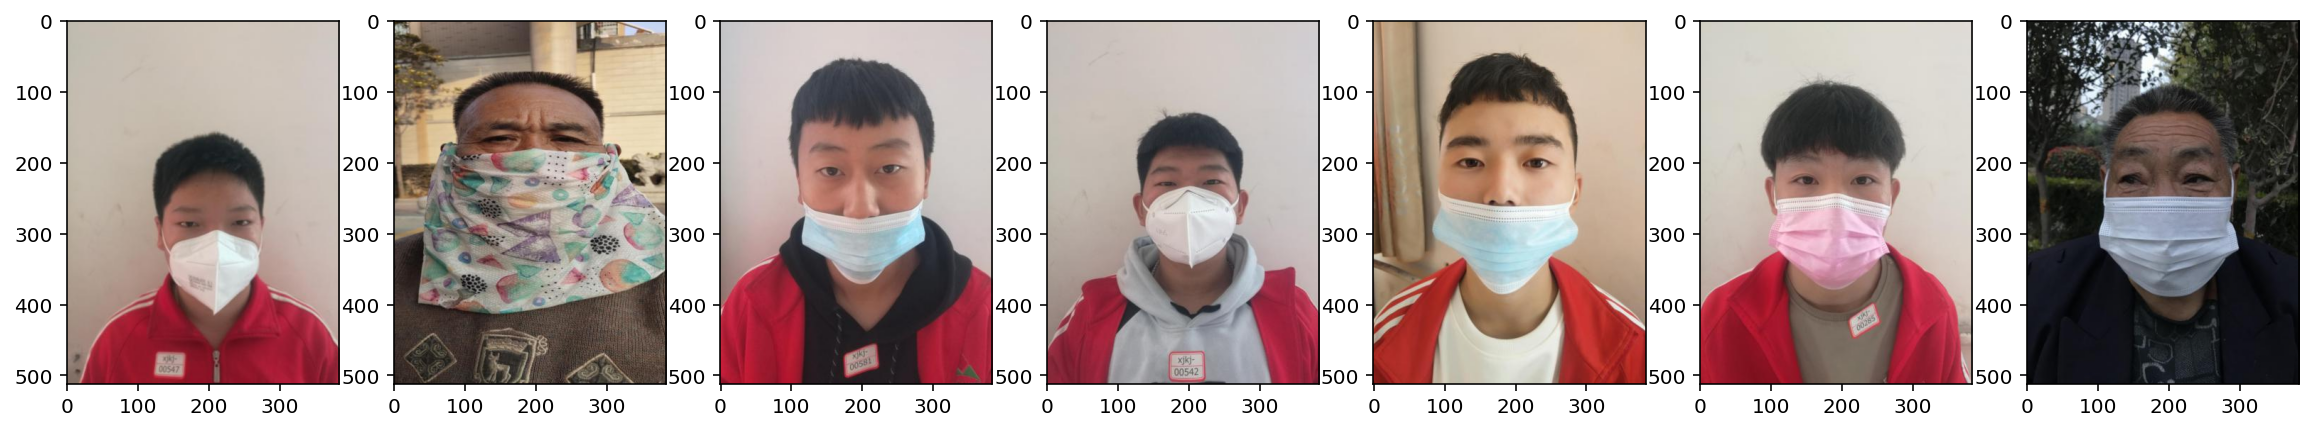

In [85]:
# test image
show_images(test_img_paths)

### 데이터셋을 본 후 결론
- 흰색 마스크만 있는 것은 아니고 다양한 색깔과 천 마스크도 존재한다
- 코스크, 턱스크, 눈스크 등의 다양한 잘못 쓴 예시가 있었다

### Metadata 분석
- 우리가 분류해야 하는 주요 특성은 마스크 유무, 성별, 연령이다
- 마스크 유무, 성별, 연령에 따른 분포를 그려보자

In [86]:
df_train["gender"].value_counts()

female    1658
male      1042
Name: gender, dtype: int64

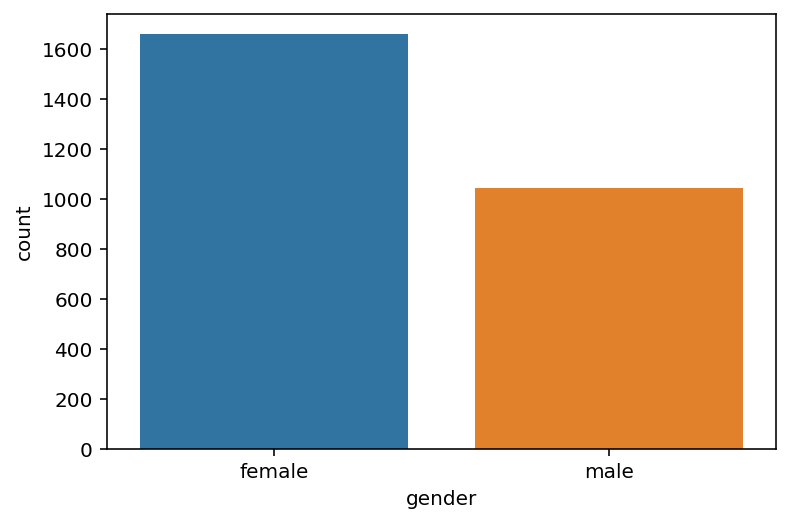

In [89]:
# x, y : numeric data
# hue : categorical data
# category에 따라 데이터가 어떻게 변하는지 볼 수 있다
sns.countplot(x="gender", data=df_train)

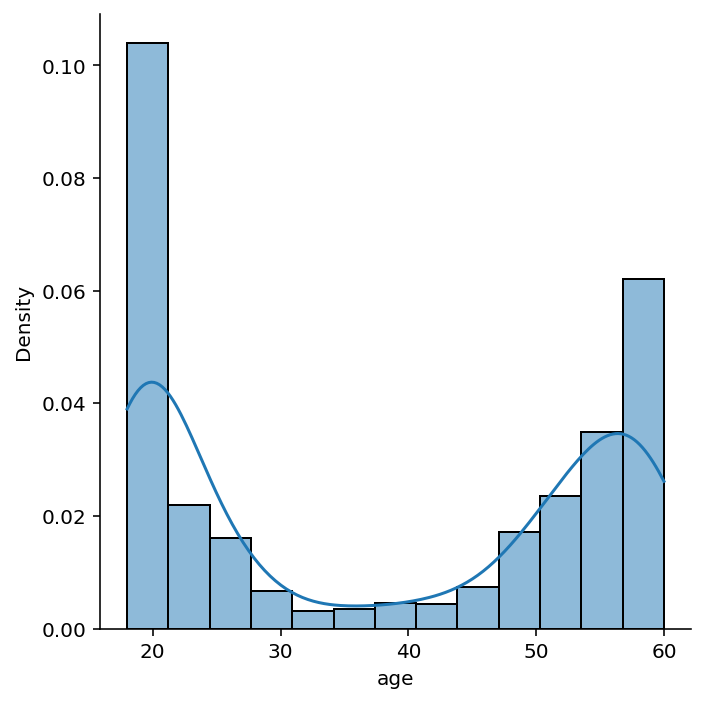

In [114]:
sns.displot(df_train, x="age", stat="density", kde=True)

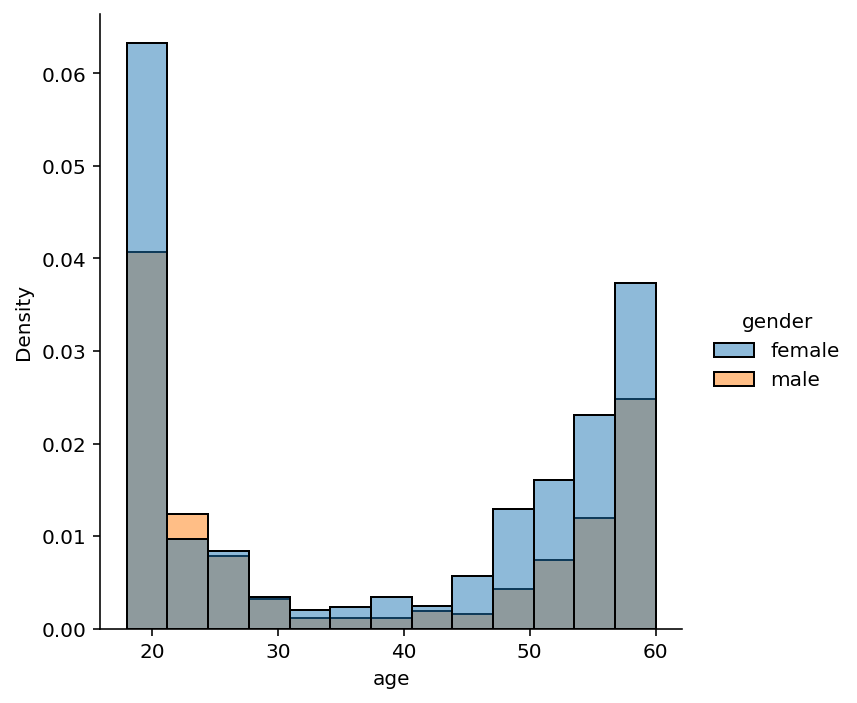

In [118]:
sns.displot(df_train, x="age", hue="gender", stat="density")

### Class Histogram
- 마스크 유무에 따른 이미지 픽셀값 분포를 확인해보자

In [53]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3', 'mask4', 'mask5', 'normal']
class2num = {k:v for v, k in enumerate(num2class)}

In [61]:
def get_extension(img_dir, img_id, class_id):
    filename = glob(os.path.join(img_dir, img_id, "*"))
    for f in filename:
        _class_id = f.split("/")[-1].split(".")[0]
        if class_id == _class_id:
            ext = os.path.splitext(f)[-1].lower()
            break
    return ext

In [62]:
img_id = df_train.iloc[500].path
img_id

'001131_female_Asian_22'

In [63]:
get_extension(cfg.img_dir, img_id, num2class[0])

'.jpg'

Text(0.5, 1.0, 'Class Grayscale Histogram Plot')

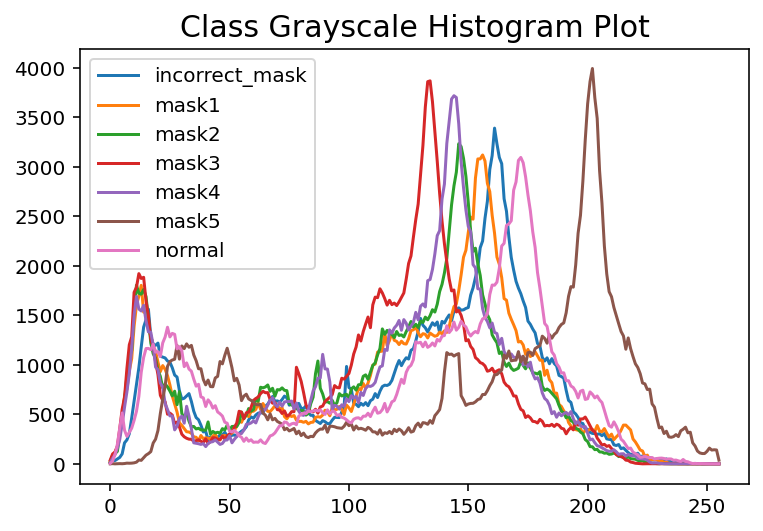

In [66]:
plt.figure()

for class_id in num2class:
    ext = get_extension(cfg.img_dir, img_id, class_id)
    # convert('L') : convert to grayscale
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)).convert('L'))
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    sns.lineplot(data=histogram)

plt.legend(num2class)
plt.title("Class Grayscale Histogram Plot", fontsize=15)

- 마스크는 평균을 취해서 확인해보기

Text(0.5, 1.0, 'Class Grayscale Histogram Plot')

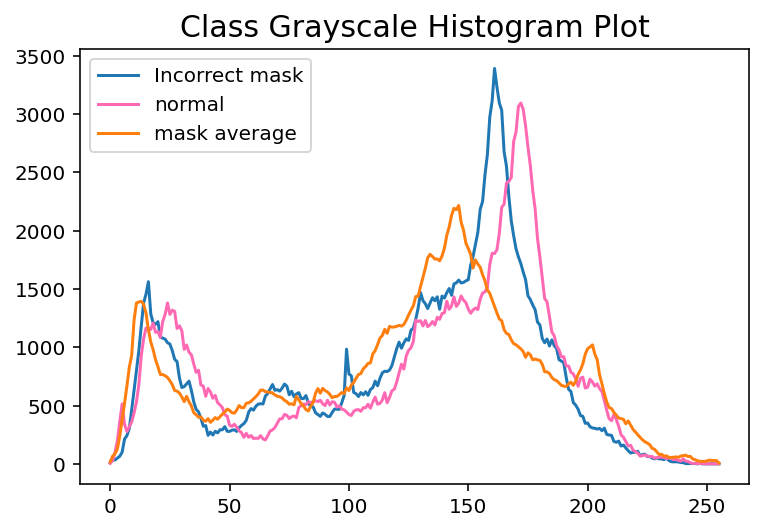

In [75]:
plt.figure()

ext = get_extension(cfg.img_dir, img_id, 'incorrect_mask')
img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'incorrect_mask' + ext)).convert('L'))
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
sns.lineplot(data=histogram)

ext = get_extension(cfg.img_dir, img_id, 'normal')
img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'normal' + ext)).convert('L'))
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
sns.lineplot(data=histogram, color="hotpink")

histograms = []
for i in range(1, 6):
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, num2class[i]+ext)).convert('L'))
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    histograms.append(histogram)
sns.lineplot(data=np.mean(histograms, axis=0))

plt.legend(['Incorrect mask', 'normal', 'mask average'])
plt.title('Class Grayscale Histogram Plot', fontsize=15)

- 마스크 쓰지 않은 사진의 RGB 분포

Text(0.5, 1.0, 'RGB Histogram Plot - Normal')

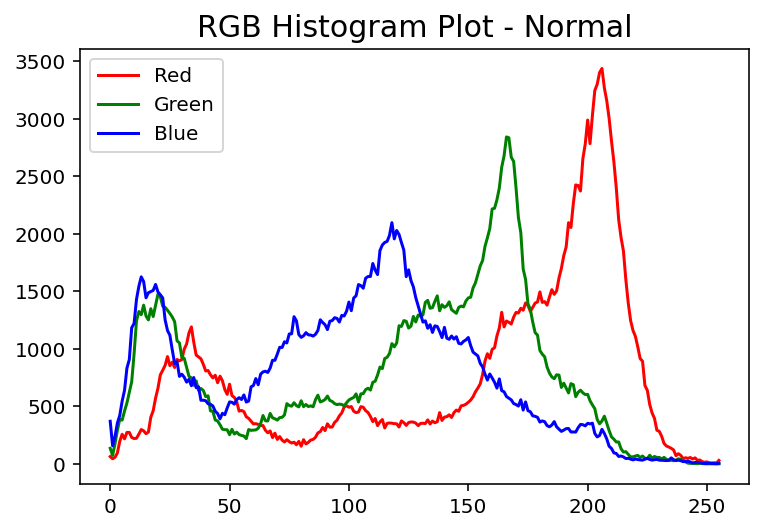

In [84]:
plt.figure()

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'normal'+ext)))
colormap = ['red', 'green', 'blue']

for i in range(3):
    histogram, bin_edges = np.histogram(img[..., i], bins=256, range=(0, 255))
    sns.lineplot(data=histogram, color=colormap[i])

plt.legend(['Red', 'Green', 'Blue'])
plt.title("RGB Histogram Plot - Normal", fontsize=15)

### Extra 분석 - Face detection
- with haar cascade

In [86]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [88]:
imgs = []
for class_id in num2class:
    ext = get_extension(cfg.img_dir, img_id, class_id)
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id + ext)))
    imgs.append(img)
imgs = np.array(imgs)

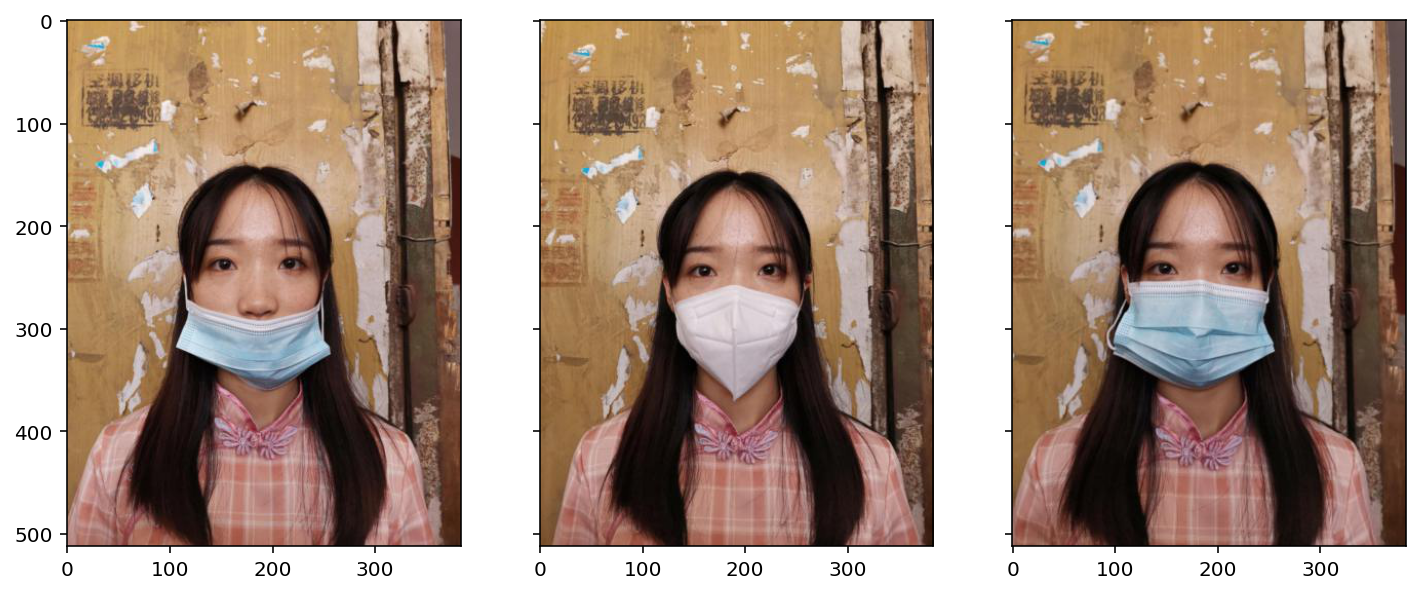

In [89]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 6))
axes[0].imshow(imgs[0])
axes[1].imshow(imgs[1])
axes[2].imshow(imgs[2])

In [92]:
for img in imgs:
    face_bbox = face_cascade.detectMultiScale(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 1.1, 4)
    for (x, y, w, h) in face_bbox:
        cv2.rectangle(img, (x,y), (x+w, y+h), (255, 0, 0), 4)

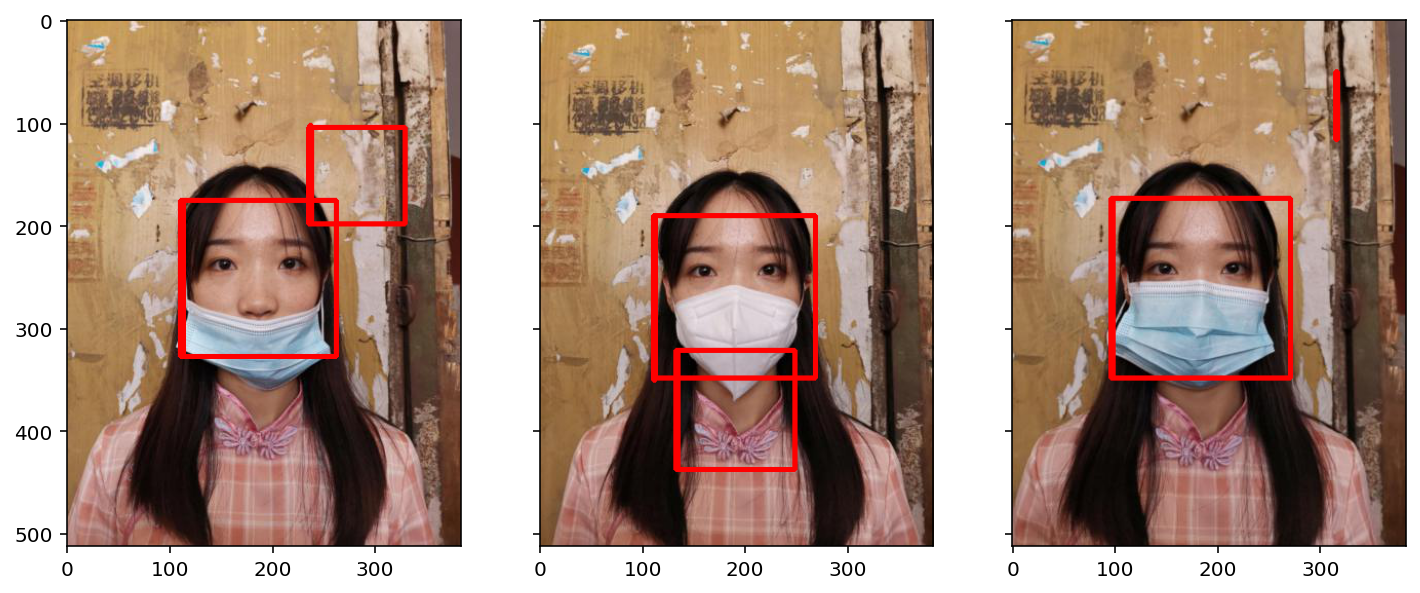

In [93]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 6))
axes[0].imshow(imgs[0])
axes[1].imshow(imgs[1])
axes[2].imshow(imgs[2])

### PCA
- 주성분 분석은 이미지의 데이터 분포의 주성분을 구하는 방법
- 300장의 얼굴 이미지에 대한 주성분 벡터(eigenface)를 구하고 T-SNE를 통해 차원축소를 해서 각 클래스마다 분포차이를 시각화해보자

In [102]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from time import time

In [108]:
n_imgs = 100

imgs = []
for img_id in df_train.path.values[:n_imgs]:
    for class_id in num2class:
        ext = get_extension(cfg.img_dir, img_id, class_id)
        img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id + ext)).convert('L'))
        imgs.append(img)

imgs = np.array(imgs)
n_samples, h, w = imgs.shape

imgs = np.reshape(imgs, (n_samples, h*w))

In [109]:
n_components = 30

t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(imgs)

print(f'pca is fitted in {time() - t0:.0f}s')
print(f'Explained variation per principal components: \n{pca.explained_variance_ratio_}')

eigenfaces = pca.components_.reshape((n_components, h, w))
img_pca = pca.transform(imgs)

pca is fitted in 6s
Explained variation per principal components: 
[0.16400588 0.10582972 0.07423492 0.05696156 0.03344151 0.02725828
 0.02416499 0.02329284 0.02024689 0.01692791 0.01573021 0.013579
 0.01292885 0.01185079 0.01141357 0.00954064 0.00822195 0.0078436
 0.00709915 0.00670269 0.00646114 0.0062662  0.00592055 0.00564922
 0.00546325 0.00517171 0.00475517 0.00465561 0.00437462 0.00422018]


In [110]:
pca_df = pd.DataFrame(img_pca, columns=[str(col) for col in range(n_components)])
pca_df['class_id'] = [num2class[n % len(num2class)] for n in range(n_samples)]
pca_df['class_id'] = pca_df['class_id'].map(lambda x: x if x in ['incorrect_mask', 'normal'] else 'mask')

In [111]:
pca_df.head()

0         1         2         3         4         5         6  \
0 -0.780943 -0.301832  0.909870  0.561611  0.377147  0.319390  0.490564   
1 -1.531008  0.054247  1.062841  0.448427  0.221644  0.127141 -0.152839   
2 -0.878984 -0.366578  0.961171  0.348036  0.147981 -0.001350  0.647854   
3 -0.354757 -0.443230  1.248900  0.964928  0.401074  0.732453  0.595657   
4 -0.526067 -0.342682  1.048815  0.778287  0.344716  0.535303  0.591965   

          7         8         9  ...        21        22        23        24  \
0 -0.157337  0.226589 -0.055673  ...  1.403316  0.697833  1.011722  1.029257   
1  2.102684  2.525257  0.799864  ... -0.563545 -0.490765 -0.530047 -0.573657   
2 -0.286916  0.415846  0.085152  ...  0.991606  0.473558  0.439318  1.320684   
3 -0.243793  0.063750  0.278081  ...  1.054658 -0.554310  0.287749  0.398944   
4 -0.187899  0.033147  0.083654  ...  1.542411  0.075677  0.999662  0.760082   

         25        26        27        28        29        class_id  
0  0.262698 -0.600548  0.042436  1.277135 -1.205663  incorrect_mask  
1  1.157760 -0.669045  0.046044  0.406874 -0.459291            mask  
2 -0.013411 -0.451588  0.018503  1.059181 -0.471109            mask  
3 -0.805110 -0.710956 -0.840587  0.874554 -0.169505            mask  
4 -0.301151 -1.019458 -0.555620  1.407125 -1.397424            mask  

[5 rows x 31 columns]

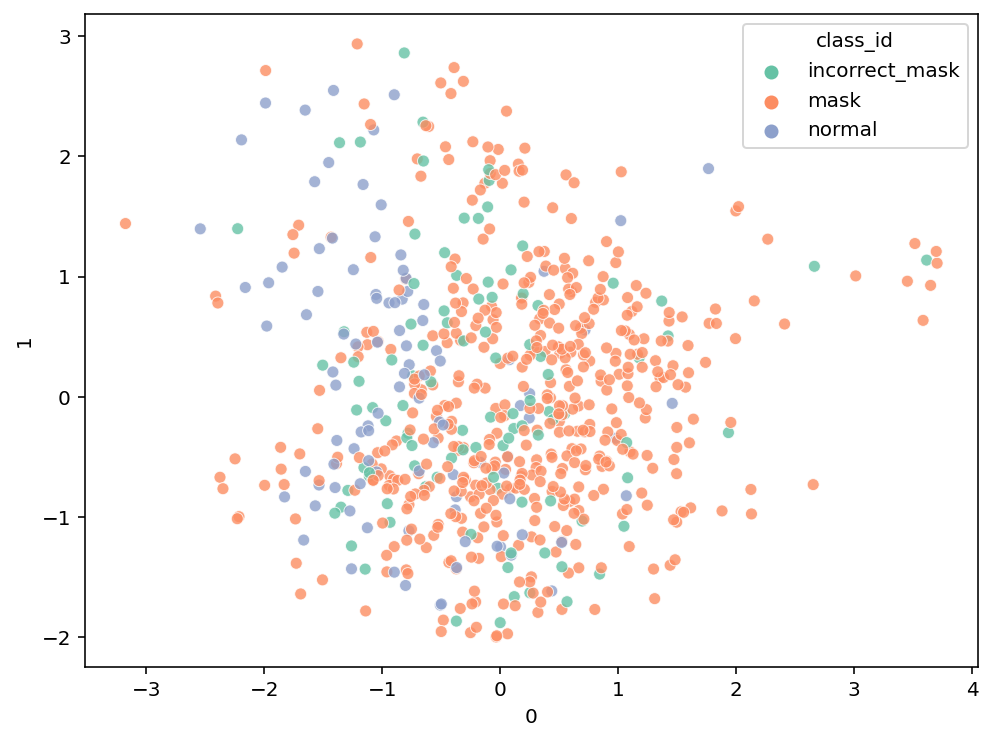

In [112]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='0', y='1',
    hue='class_id',
    data=pca_df,
    legend='full',
    palette=sns.color_palette("Set2", 3),
    alpha=0.8
)

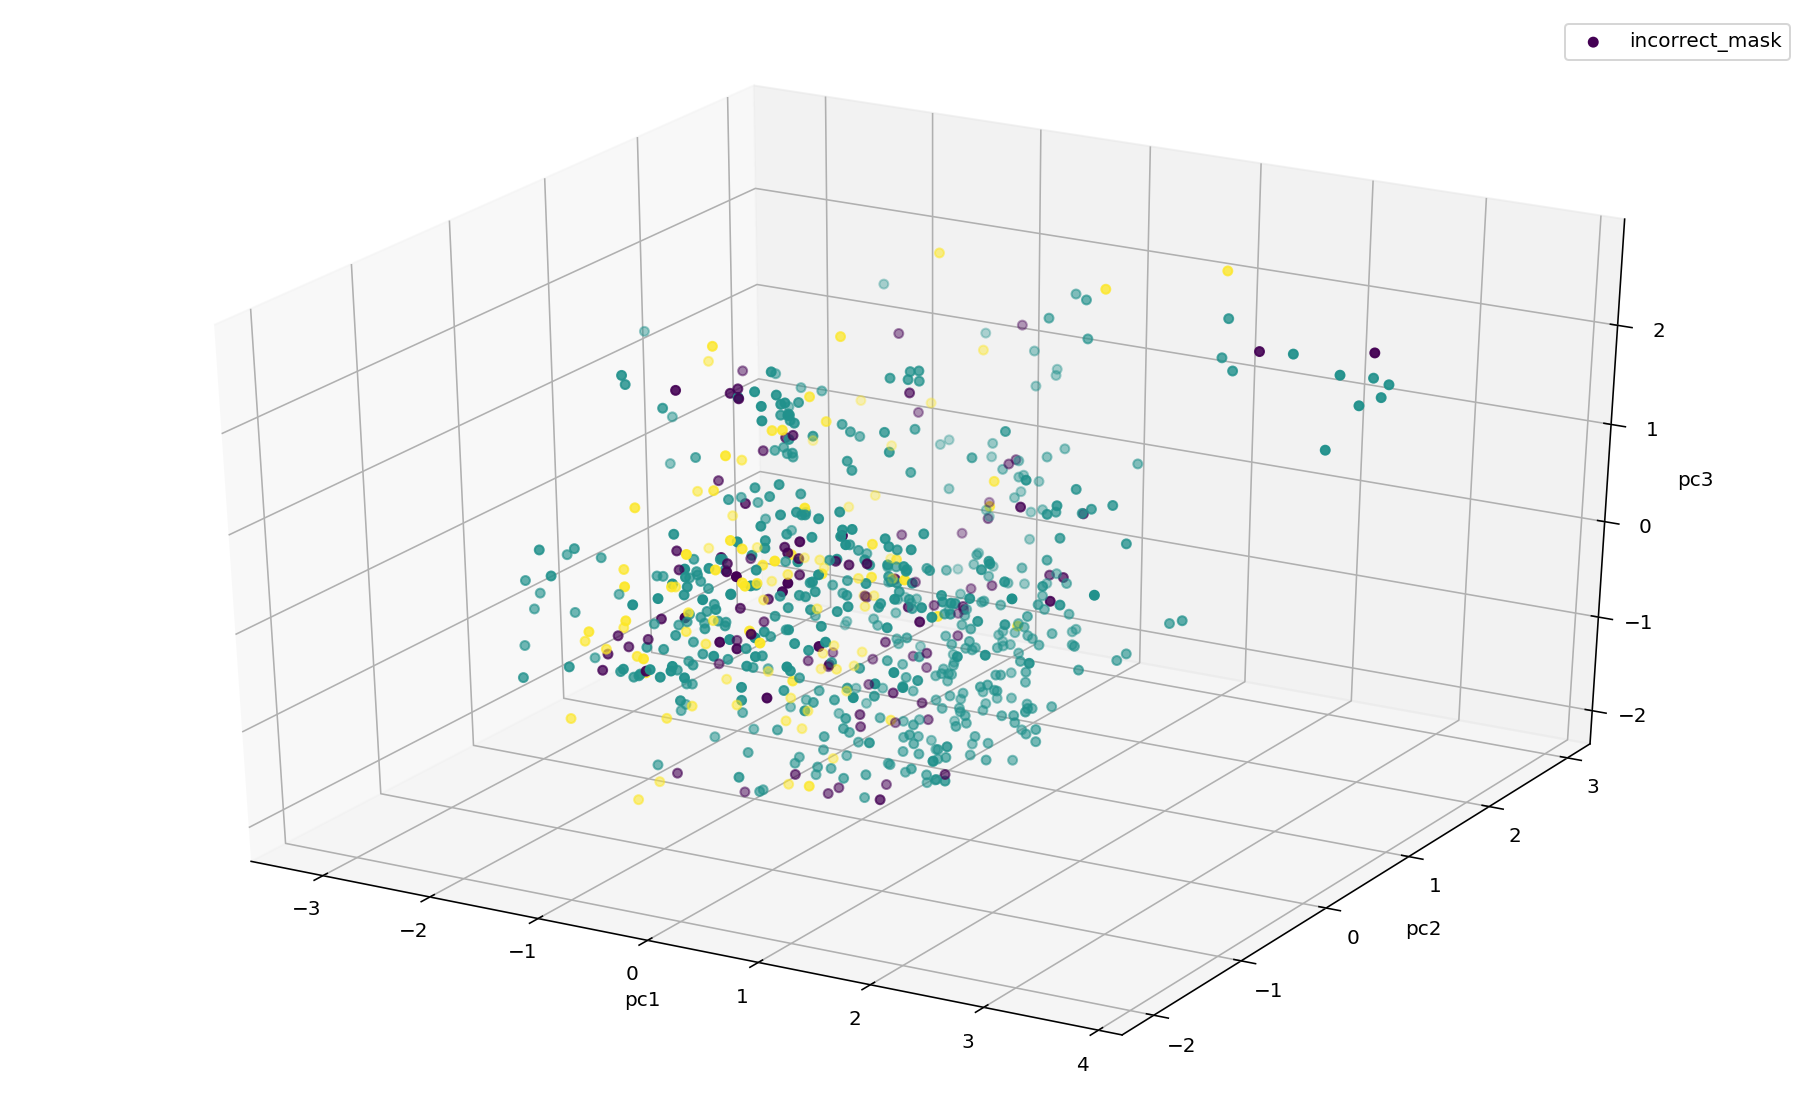

In [118]:
ax = plt.figure(figsize=(16, 10)).gca(projection='3d')
simplified_num2class = ['incorrect_mask', 'mask', 'normal']
simplified_class2num = {k:v for v, k in enumerate(simplified_num2class)}
ax.scatter(
    xs=pca_df["0"],
    ys=pca_df["1"],
    zs=pca_df["2"],
    c=pca_df["class_id"].map(lambda x: simplified_class2num[x]),
)

ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')

plt.legend(simplified_num2class)
plt.show()

In [119]:
time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(img_pca)
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 700 samples in 0.000s...
[t-SNE] Computed neighbors for 700 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 700 / 700
[t-SNE] Mean sigma: 2.323025
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.170036
[t-SNE] KL divergence after 300 iterations: 1.302367
t-SNE done! Time elapsed: 0.9314694404602051 seconds


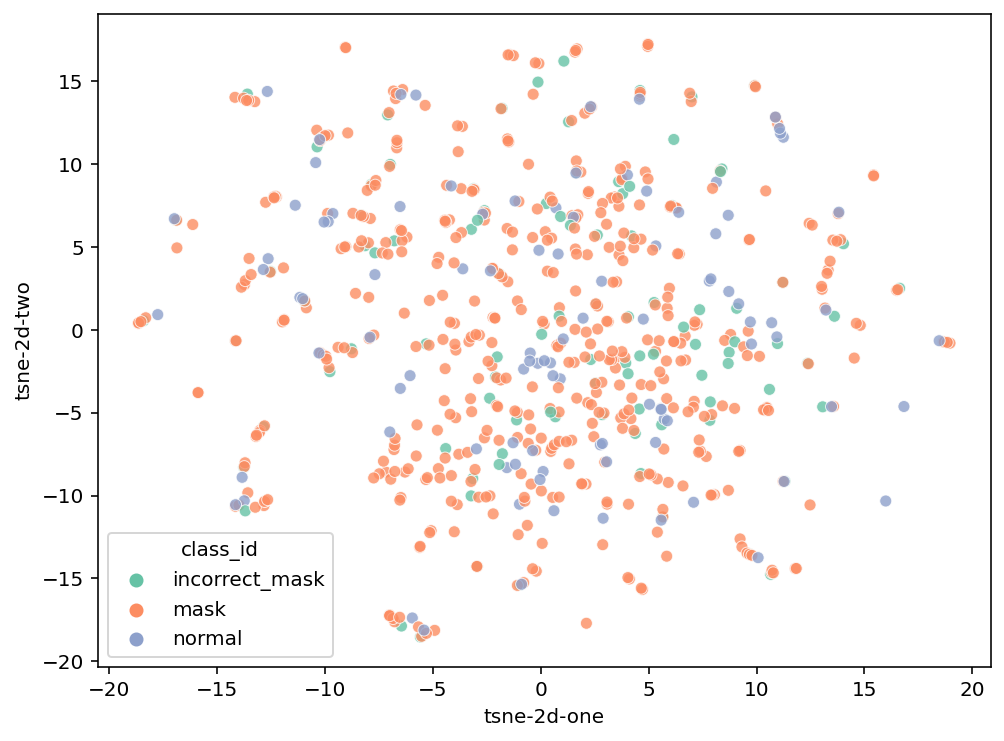

In [120]:
pca_df['tsne-2d-one'] = tsne_results[:,0]
pca_df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class_id",
    palette=sns.color_palette("Set2", 3),
    data=pca_df,
    legend="full",
    alpha=0.8
)

### Reference
- [Visualising high-dimensional datasets using PCA and t-SNE in Python](https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)
- [Faces recognition example using eigenfaces and SVMs](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html)
- [Seaborn docs](https://seaborn.pydata.org/index.html)
- [Face Detection in 2 Minutes using OpenCV & Python](https://towardsdatascience.com/face-detection-in-2-minutes-using-opencv-python-90f89d7c0f81)